In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter
import random
import cv2
from time import time

import torch 
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torchvision import datasets
import torch.nn as nn
from torchvision.transforms import ToTensor 
import torchvision.transforms as transforms 
from torch.utils.data import Dataset

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [166]:
train_data = pd.read_csv(r'train.csv')
test_data = pd.read_csv(r'test.csv')
sample = pd.read_csv(r'sample_submission.csv')

In [167]:
display(train_data.head(10))
display(test_data.head(1))

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (42000, 785)
Test data shape: (28000, 784)


In [169]:
Y = train_data['label']
X = train_data.drop(['label'], axis = 1)

# Normalize the data
X = X / 255.0
val = test_data / 255.0

X.describe().round(2)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.00,42000.00,42000.00,42000.00,42000.00,42000.00,42000.0,42000.0,42000.0,42000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.02,0.02,0.01,0.01,0.01,0.00,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00,1.00,0.99,0.99,1.00,0.24,0.0,0.0,0.0,0.0


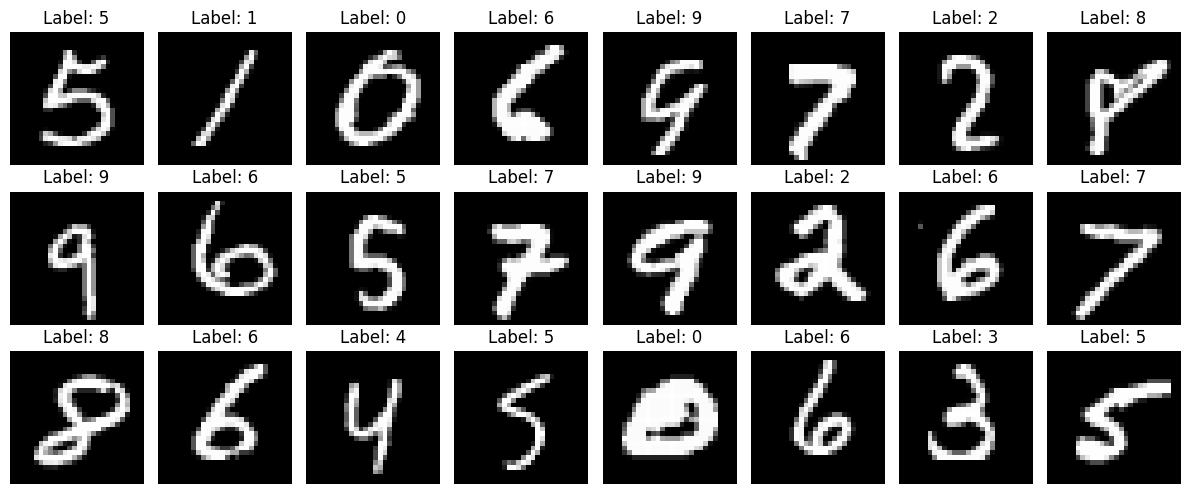

In [170]:
# Vizualization of images and its labels
fig, axes = plt.subplots(3,8, figsize = (12,5))
axes = axes.flatten()
indices = random.sample(range(len(train_data)), 24)

for i, idx in enumerate(indices):
    image = train_data.iloc[idx, 1:].values.reshape(28, 28)  # Reshape from 1D to 2D
    label = train_data.iloc[idx, 0]  # Labelling
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

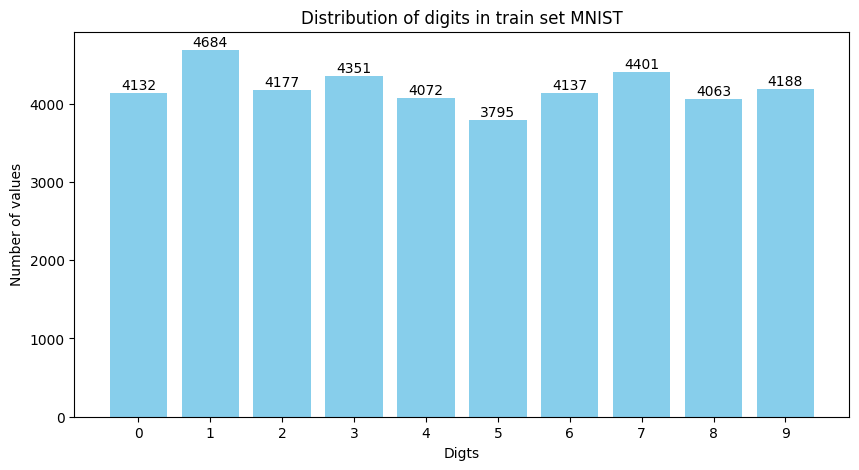

In [171]:
def bar_values(bars):
    '''The function adds labels to the bars in the bar chart.'''
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 5, int(height),
                 ha='center', va='bottom')
        
#Count the number of occurrences of each label
label_counter = Y.value_counts().sort_index()

plt.figure(figsize=(10, 5))
bars = plt.bar(label_counter.index, label_counter.values, color='skyblue')
bar_values(bars)

plt.xticks(range(10))
plt.xlabel('Digts')
plt.ylabel('Number of values')
plt.title('Distribution of digits in train set MNIST')
plt.show()

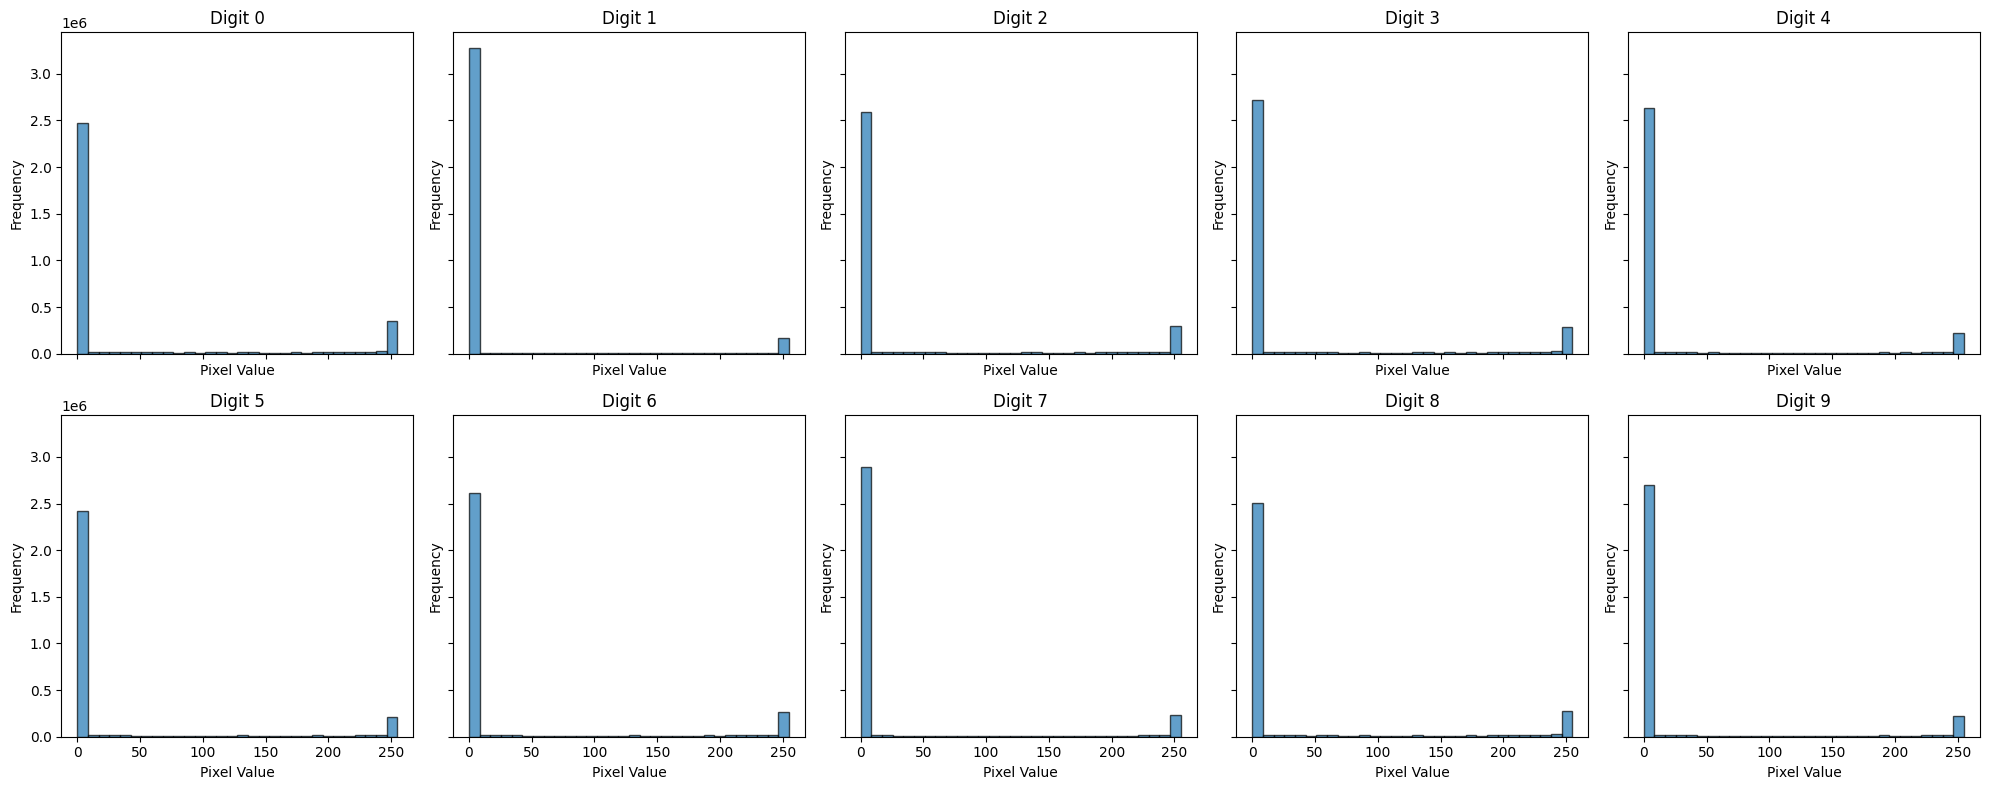

In [172]:
digit_pixel_values = {i: [] for i in range(10)}

# Iteration through the DataFrame rows
for _, row in train_data.iterrows():
    label = row['label']
    pixels = row.drop('label').values  # Retrieve pixel values (all columns except ‘label’)
    digit_pixel_values[label].extend(pixels)


fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(10):
    axes[i].hist(digit_pixel_values[i], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Digit {i}')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [173]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42, shuffle=True)

In [174]:
print("X_train shape is : ",X_train.shape)
print("Y_train shape is : ", Y_train.shape)
print("X_test shape is " , X_test.shape)
print("Y_test shape is " , Y_test.shape)

X_train shape is :  (33600, 784)
Y_train shape is :  (33600,)
X_test shape is  (8400, 784)
Y_test shape is  (8400,)


In [175]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, Y_train)
y_pred = logistic_regression.predict(X_test)

acc_logr = round(accuracy_score(Y_test, y_pred) * 100, 2)
conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred)

print(f"Accuracy on validation data: {acc_logr}%")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy on validation data: 92.17%
Confusion Matrix:
[[789   0   1   1   3  13   7   0   2   0]
 [  0 888   4   0   1   4   1   2   7   2]
 [  4  11 762  11  13   7  11   8  18   1]
 [  1   3  25 828   0  33   2   7  23  15]
 [  3   2   4   1 787   2   9   4   4  23]
 [  8   2   6  22   8 621  18   3  11   3]
 [  7   1   6   0   4   8 754   1   3   1]
 [  0   2  10   7  11   4   0 825   3  31]
 [  3  12   6  29   7  27   6   4 736   5]
 [  6   4   3  13  18   5   0  30   7 752]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       816
           1       0.96      0.98      0.97       909
           2       0.92      0.90      0.91       846
           3       0.91      0.88      0.90       937
           4       0.92      0.94      0.93       839
           5       0.86      0.88      0.87       702
           6       0.93      0.96      0.95       785
           7       0.93      0.92      0.93       893
     

/Users/franekbiskup/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [176]:
train_conf_matrix = confusion_matrix(Y_train, logistic_regression.predict(X_train))
train_conf_matrix

array([[3240,    0,    6,    5,    3,   21,   19,    4,   15,    3],
       [   0, 3695,   12,   15,    3,   11,    2,    6,   26,    5],
       [   7,   27, 3056,   49,   34,   11,   26,   34,   70,   17],
       [   7,   13,   65, 3128,    3,   97,    9,   21,   45,   26],
       [   5,   14,   14,    4, 3066,    4,   21,    8,   13,   84],
       [  24,    9,   22,   89,   29, 2792,   37,    8,   60,   23],
       [  16,    5,   12,    0,   17,   33, 3260,    1,    7,    1],
       [   5,   12,   37,    9,   17,    5,    3, 3328,    4,   88],
       [  20,   52,   20,   76,   11,   54,   13,    8, 2934,   40],
       [  13,   12,    7,   34,   64,   19,    0,   87,   25, 3089]])

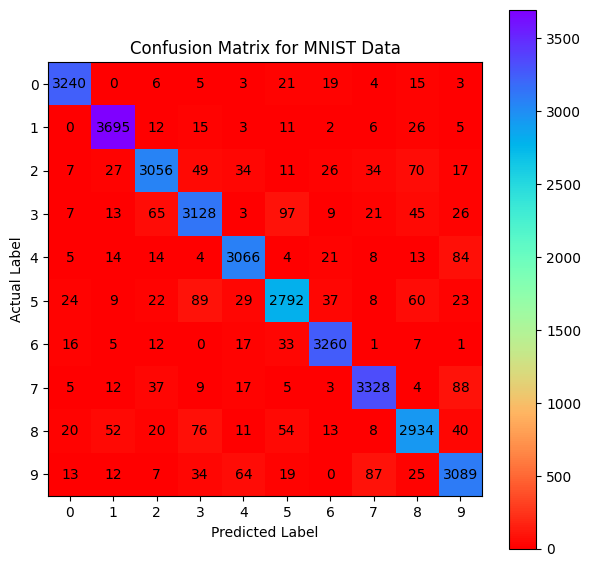

In [177]:
plt.figure(figsize=(7,7))
plt.imshow(train_conf_matrix,cmap='rainbow_r')
plt.title("Confusion Matrix for MNIST Data")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.colorbar()

width,height = train_conf_matrix.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(train_conf_matrix[x][y]),xy=(y,x),horizontalalignment='center',verticalalignment='center')
plt.show()

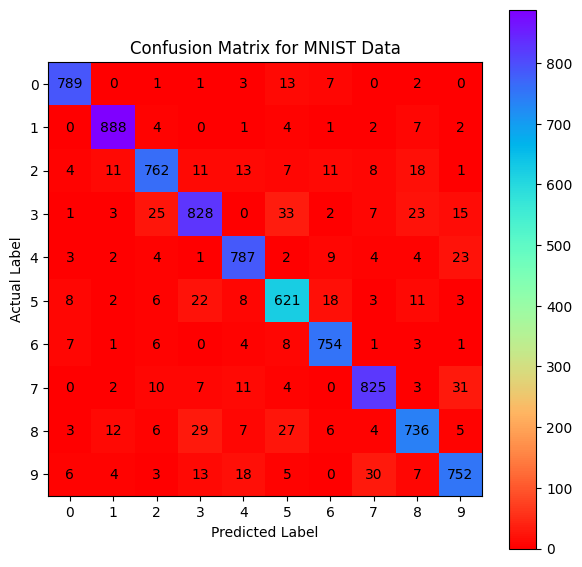

In [178]:
plt.figure(figsize=(7,7))
plt.imshow(conf_matrix,cmap='rainbow_r')
plt.title("Confusion Matrix for MNIST Data")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.colorbar()

width,height = conf_matrix.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(conf_matrix[x][y]),xy=(y,x),horizontalalignment='center',verticalalignment='center')
plt.show()

In [179]:
Y_train.dtype

dtype('int64')

In [180]:
Y_train.head(10)

34941    6
24433    5
24432    3
8832     4
30291    7
28009    8
27876    6
120      7
30457    0
4634     9
Name: label, dtype: int64

# Deep learning 

In [181]:
def df_to_tensor(df):
    df = df.astype(float)
    numpy_array = df.values
    to_tensor = torch.tensor(numpy_array, dtype=torch.float32)
    return to_tensor

In [182]:
X_d_train = df_to_tensor(X_train)
Y_d_train = df_to_tensor(Y_train)

#X_d_test = df_to_tensor
#Y_d_test = df_to_tensor


In [183]:
class Data(Dataset):
    def __init__(self, X , Y):
        self.X = torch.tensor(X.values, dtype= torch.float32)
        self.Y = torch.tensor(Y.values, dtype= torch.long)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
train_dataset = Data(X_train, Y_train)
test_dataset = Data(X_test, Y_test)

In [184]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

In [185]:
class nnClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 10)

        self.dropout = nn.Dropout(p = 0.2)
        self.log_softmax = F.log_softmax

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))

        x = self.log_softmax(self.fc5(x), dim = 1)

        return x

In [186]:
model = nnClassifier()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [187]:
num_epochs = 150

losses = []
accuracies = []

for epoch in range(num_epochs):
    correct = 0
    total = 0
    running_loss = 0.0
    
    for data in train_loader:
        # Downloading data from the dataloader
        inputs, targets = data
        # Zeroing gradients
        optimizer.zero_grad()
        # Prediction
        pred = model(inputs)
        # Loss calculation
        loss = criterion(pred, targets)
        # Backpropagation (calculation of gradients)
        loss.backward()
        # Weights update
        optimizer.step()
        # Summary of losses to be displayed
        running_loss += loss.item()
        # Class prediction (choose the index of the largest value)
        _, predicted = torch.max(pred.data, 1)
        # Counting correct predictions
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    # Calculation of the accuracy for a given epoch
    accuracy = 100 * correct / total
    # Recording loss and accuracy
    losses.append(running_loss / len(train_loader))
    accuracies.append(accuracy)


    if (epoch + 1) == 1  or (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


Epoch 1/150, Loss: 2.3041, Accuracy: 8.93%
Epoch 10/150, Loss: 2.2629, Accuracy: 23.43%
Epoch 20/150, Loss: 1.2136, Accuracy: 56.42%
Epoch 30/150, Loss: 0.7419, Accuracy: 76.12%
Epoch 40/150, Loss: 0.5020, Accuracy: 85.11%
Epoch 50/150, Loss: 0.3763, Accuracy: 89.33%
Epoch 60/150, Loss: 0.2953, Accuracy: 91.79%
Epoch 70/150, Loss: 0.2438, Accuracy: 93.41%
Epoch 80/150, Loss: 0.2099, Accuracy: 94.26%
Epoch 90/150, Loss: 0.1784, Accuracy: 95.12%
Epoch 100/150, Loss: 0.1546, Accuracy: 95.79%
Epoch 110/150, Loss: 0.1352, Accuracy: 96.30%
Epoch 120/150, Loss: 0.1203, Accuracy: 96.75%
Epoch 130/150, Loss: 0.1025, Accuracy: 97.27%
Epoch 140/150, Loss: 0.0930, Accuracy: 97.46%
Epoch 150/150, Loss: 0.0837, Accuracy: 97.66%


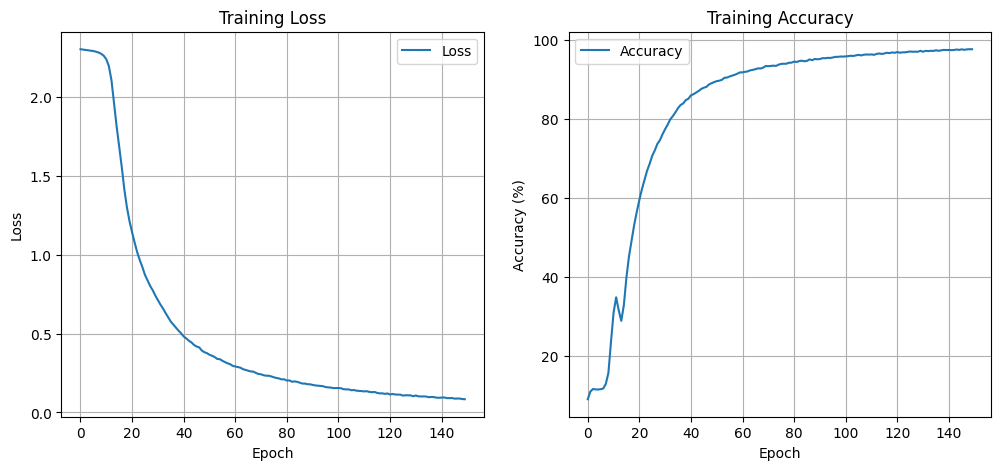

In [188]:
# Loss and accuracy plots
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

plt.show()